# Dog Breed Classification

## Dataset

In [ ]:
import torch
import random
import matplotlib.pyplot as plt
import kagglehub
import os

from torchvision import transforms
from PIL import Image, ImageFile
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import LabelEncoder
from torch.amp import GradScaler, autocast
from torchvision.transforms import Lambda

In [10]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

torch.cuda.set_per_process_memory_fraction(0.8, device=try_gpu())
torch.set_num_threads(4)

In [11]:
# Download latest version
path = kagglehub.dataset_download("yxshee/dogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/silvia/.cache/kagglehub/datasets/yxshee/dogs-dataset/versions/2


In [12]:
path_data = path + '/images/Images'

In [13]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

class DogBreed_Dataset(Dataset):
    def __init__(self, path_data, transform=None, target_transform=None):
        self.path_data = path_data

        self.labels = [name for name in os.listdir(self.path_data) 
                    if os.path.isdir(os.path.join(self.path_data, name))]

        self.train = []
        self.target = []
        for label in self.labels:
            path_images = os.path.join(self.path_data, label)
            for path_image in os.listdir(path_images):
                try:
                    image = Image.open(os.path.join(path_images, path_image)).convert('RGB')
                except Exception as e:
                    print(f"Error loading an image {os.path.join(path_images, path_image)}: {e}")
                    
                self.train.append(image)
                self.target.append(label)
        
        self.transform = transform
        self.target_transform = target_transform

        self.encoder = LabelEncoder().fit(self.labels)

    def __len__(self):
        return len(self.train)
    
    def target_len(self):
        return len(self.labels)

    def get_label_str(self, label_int):
        return self.encoder.inverse_transform([label_int])

    def __getitem__(self, idx):
        image = self.train[idx]
        label = self.encoder.transform([self.target[idx]])
        label = label[0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
data = DogBreed_Dataset(path_data)

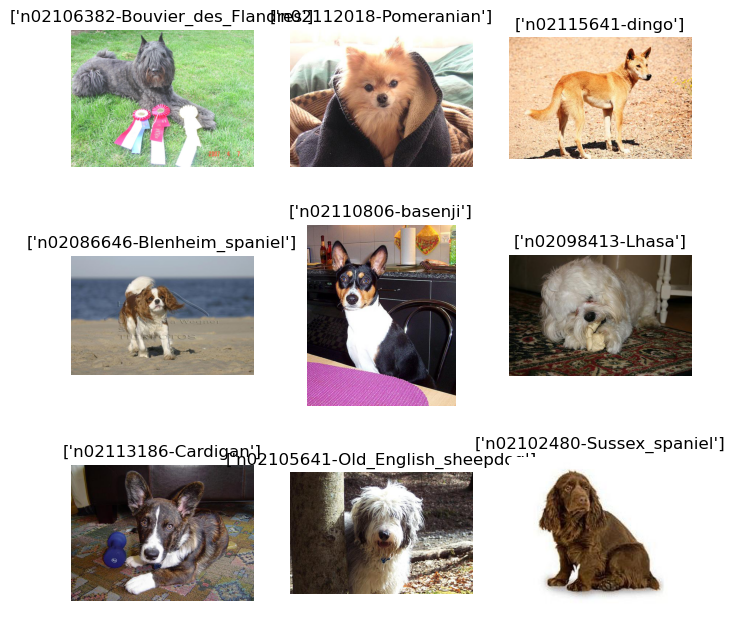

In [ ]:
figure = plt.figure(figsize=(8, 8))
fils, cols = 3, 3

for i in range(1, cols * fils + 1):
    sample_idx = random.randint(0, len(data) - 1)
    img, label = data[sample_idx]

    figure.add_subplot(fils, cols, i)
    plt.title(str(data.get_label_str(label)))
    plt.axis("off")

    plt.imshow(img, cmap="gray") # Imagen
plt.show()

In [ ]:
print(f'Image data type: {type(img)}')
print(f'Image size: {img.size}')
print(f'Min and max of the image: {img.min()}, {img.max()}')
print(f'Target data type: {type(label)}')

Image data type: <class 'PIL.Image.Image'>


AttributeError: 'Image' object has no attribute 'shape'

In [ ]:
print(f'Size of the set: {len(data)}')

Size of the set: 20580


In [ ]:
torch.manual_seed(746278)

train, val = torch.utils.data.random_split(
    data, [0.8, 0.2]
)

print(f'Size of the train set: {len(train)}')
print(f'Size of the val set: {len(val)}')

Size of the train set: 16464
Size of the val set: 4116


## Model

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = layers
    
    def init_cnn(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        logits = self.net(x)
        return logits

In [ ]:
model = ConvNetwork(
    nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.Sigmoid(),
        nn.Dropout(p=0.4),
        nn.LazyLinear(84), nn.Sigmoid(),
        nn.Dropout(p=0.4),
        nn.LazyLinear(data.target_len())
    )
).to(try_gpu())

print(model)

ConvNetwork(
  (net): Sequential(
    (0): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=120, bias=True)
    (8): Sigmoid()
    (9): Dropout(p=0.5, inplace=False)
    (10): LazyLinear(in_features=0, out_features=84, bias=True)
    (11): Sigmoid()
    (12): Dropout(p=0.5, inplace=False)
    (13): LazyLinear(in_features=0, out_features=120, bias=True)
  )
)


In [ ]:
BATCH_SIZE = 16

def worker_init_fn(worker_id):
    torch.manual_seed(worker_id)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transforms each batch
transform_batch = Lambda(lambda batch: torch.stack([transform(img) for img in batch]))

train_loader = DataLoader(
    dataset=train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2, 
    pin_memory=True,
    collate_fn=transform_batch,
    worker_init_fn=worker_init_fn
)

val_loader = DataLoader(
    dataset=val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=transform_batch
)

In [ ]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer='SGD', lr=0.1, epochs=10, device=try_gpu()):
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr
        self.optimizer = self.get_optimizer(optimizer)
        self.n_epochs = epochs
        self.device = device

    def get_optimizer(self, optim):
        if (optim == 'Adam'):
            return torch.optim.Adam(self.model.parameters(), lr=self.lr)
        elif (optim == 'ASGD'):
            return torch.optim.ASGD(self.model.parameters(), lr=self.lr)
        elif (optim == 'NAdam'):
            return torch.optim.NAdam(self.model.parameters(), lr=self.lr)
        elif (optim == 'Adadelta'):
            return torch.optim.Adadelta(self.model.parameters(), lr=self.lr)
        else:
            return torch.optim.SGD(self.model.parameters(), lr=self.lr)

    def _train_loop(self, epoch, train_loader):
        train_size = len(train_loader.dataset)

        # Telling pytorch that we are training
        self.model.train()

        scaler = GradScaler(self.device)

        train_loss, accuracy = 0, 0
        for n_batches, (X, y) in enumerate(train_loader):
            X, y = X.to(self.device), y.to(self.device)

            with autocast('cuda'):
                logits = self.model(X)
                
                # Xavier initialization
                if epoch == 0 and n_batches == 0:
                    self.model.init_cnn()
                    logits = self.model(X)

                loss = self.loss_fn(logits, y)
    
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            self.optimizer.zero_grad()

            # Accumulate loss and accuracy
            # train_loss <- train_loss + current_loss
            # accuracy <- accuracy + n_successes_current
            train_loss += loss.item()
            accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

            # Training evolution (each 10 batches)
            if n_batches % 10 == 0:
                # Number of data processed
                ndata = n_batches * BATCH_SIZE
                print(f"\tLoss: {loss.item():>7f}  [{ndata:>5d}/{train_size:>5d}]")

        # Average loss and accuracy
        train_loss /= n_batches
        accuracy /= train_size

        print(f'\tAverage accuracy/loss:')
        print(f'\t\tTraining: {(100*accuracy):>0.1f}% / {train_loss:>8f}')

        return train_loss, accuracy

    def _val_loop(self, val_loader):
        val_size = len(val_loader.dataset)
        n_batches = len(val_loader)

        # Telling pytorch that we are evaluaiting
        self.model.eval()

        val_loss, accuracy = 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(self.device), y.to(self.device)

                # Forward propagation
                logits = model(X)

                # Accumulate loss and accuracy
                # val_loss <- val_loss + current_loss
                # accuracy <- accuracy + n_successes_current
                val_loss += self.loss_fn(logits, y).item()
                accuracy += (logits.argmax(1) == y).type(torch.float).sum().item()

        # Average loss and accuracy
        val_loss /= n_batches
        accuracy /= val_size

        print(f'\tAverage accuracy/loss:')
        print(f'\t\tValidation: {(100*accuracy):>0.1f}% / {val_loss:>8f}')

        return val_loss, accuracy

    def fit(self, train_loader, val_loader):
        # writer = SummaryWriter(writer_name)

        # Lists for keeping the metrics
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch+1}/{self.n_epochs}\n-------------------------------")

            train_loss, train_accuracy = self._train_loop(epoch, train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Register the loss in TensorBoard
            # writer.add_scalar("Loss/Training", train_loss, epoch)

            # Register the accuracy
            # writer.add_scalar("Accuracy/Training", train_accuracy, epoch)

            val_loss, val_accuracy = self._val_loop(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # Register the loss in TensorBoard
            # writer.add_scalar("Loss/Validation", val_loss, epoch)

            # Register the accuracy
            # writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

            # Clean VRAM after every epoch
            torch.cuda.empty_cache()

        self._draw_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

        # writer.close()

    def predict(self, img):
        logits = self.model(img.to(self.device))

        plt.imshow(img.permute(1, 2, 0), cmap="gray")
        print(logits.argmax(1).item())

    def _draw_metrics(self, train_losses, train_accuracies, val_losses, val_accuracies):
        plt.figure(figsize=(12, 6))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Evolution")
        plt.legend()

        # Gráfico de precisión
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="Train Accuracy")
        plt.plot(val_accuracies, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Evolution")
        plt.legend()

        # Mostrar los gráficos
        plt.tight_layout()
        plt.show()


In [ ]:
trainer = Trainer(model, nn.CrossEntropyLoss(), 'SGD', lr=0.1, epochs=20)
trainer.fit(train_loader, val_loader)

Epoch 1/20
-------------------------------


	Loss: 4.739014  [    0/16464]
	Loss: 4.854980  [  160/16464]
	Loss: 5.052246  [  320/16464]
	Loss: 4.976807  [  480/16464]
	Loss: 4.988037  [  640/16464]
	Loss: 4.854004  [  800/16464]
	Loss: 4.778809  [  960/16464]
	Loss: 4.817627  [ 1120/16464]
	Loss: 4.897705  [ 1280/16464]
	Loss: 4.839111  [ 1440/16464]
	Loss: 4.985107  [ 1600/16464]
	Loss: 4.823486  [ 1760/16464]
	Loss: 4.756104  [ 1920/16464]
	Loss: 4.967773  [ 2080/16464]
	Loss: 4.738037  [ 2240/16464]
	Loss: 4.583862  [ 2400/16464]
	Loss: 4.821655  [ 2560/16464]
	Loss: 4.662476  [ 2720/16464]
	Loss: 4.942139  [ 2880/16464]
	Loss: 4.766113  [ 3040/16464]


KeyboardInterrupt: 